# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
from transformers import AdamW
import pickle
from sklearn.feature_selection import mutual_info_classif
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score,precision_score , roc_auc_score
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

     |████████████████████████████████| 3.5 MB 8.5 MB/s 
     |████████████████████████████████| 6.8 MB 59.3 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 39.7 MB/s 
     |████████████████████████████████| 895 kB 54.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 316 kB 7.1 MB/s 
     |████████████████████████████████| 1.4 MB 12.3 MB/s 
     |████████████████████████████████| 233 kB 38.7 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394490 sha256=e18d644aa080a9f61c7ca1681e8426dfa02e7f59e366ee291e820b606d0be410
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154457 sha256=473575220b85b2d61edced3014be8b86197

# Loading & Preprocessing data

In [2]:
# downloading data

# downloading persian stopwords


Downloading...
From: https://drive.google.com/uc?id=1KpJCXTkuy1NLR5MgXsoYfBsv_OnwJqIF
To: /content/AI_NEWS.csv
100% 16.8M/16.8M [00:00<00:00, 77.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qiq2I8EdTcgn2Wc03XqucUcMhBdVhEre
To: /content/stopwords.txt
100% 3.66k/3.66k [00:00<00:00, 5.71MB/s]


In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

In [8]:
# a function to print evaluation using given predicted labels and real labels
def print_evaluation(real, pred):
    f1macro = f1_score(real, pred, average= 'weighted')
    f1micro = f1_score(real, pred, average='micro')
    acc = accuracy_score(real, pred)
    recall = recall_score(real, pred, average= 'macro', zero_division=0) #zero_division=1
    precision = precision_score(real, pred, average= 'macro') #,zero_division=1
    rocauc = roc_auc_score(real, pred, average= 'weighted')
    print(f'f1-score macro: {f1macro}')
    print(f'f1-score micro: {f1micro}')
    print(f'accuracy score: {acc}')
    print(f'recall score: {recall}')
    print(f'precision score: {precision}')
    print(f'ROCAUC score: {rocauc}')

In [9]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:50<00:00, 36.26it/s]


# Reading files

In [10]:
with open('lr_pred', 'rb') as f:
  lr_pred = pickle.load(f)

with open('lr_prob', 'rb') as f:
  lr_prob = pickle.load(f)

with open('roberta_pred', 'rb') as f:
  roberta_pred = pickle.load(f)

with open('roberta_prob', 'rb') as f:
  roberta_prob = pickle.load(f)

with open('test_lstm.pkl', 'rb') as f:
  lstm = pickle.load(f)

In [11]:
all_categories = []
for news in news_data:
  all_categories.append(news.category)
  categories = np.unique(all_categories)
categories = list(categories)

In [12]:
category_matrix = np.zeros(shape=(len(test_data), len(categories)), dtype=np.int64)

In [13]:
for i, data in enumerate(test_data):
  index = categories.index(data.category)
  category_matrix[i, index] = 1

In [14]:
lstm_pred = np.argmax(lstm, axis=1)
lstm_prob = np.amax(lstm, axis=1)

In [15]:
lr_category_mutual = mutual_info_classif(category_matrix, lr_pred)
roberta_category_mutual = mutual_info_classif(category_matrix, roberta_pred)
lstm_category_mutual = mutual_info_classif(category_matrix, lstm_pred)

# Compute Mutual Information of Categories

## Logistic Regression

In [16]:
print('Logistic Regression Category Mutual Information')
for i in range(len(categories)):
  print(categories[i],'-->',lr_category_mutual[i])

Logistic Regression Category Mutual Information
اجتماعی --> 0.029697166109571738
اقتصادی --> 0.026101939468282875
بین الملل --> 0.023554850151957796
حوادث --> 0.018625982350700676
سیاسی --> 0.010467847370794425
علمی و پزشکی --> 0.01435428777387604
فرهنگ و هنر --> 0.03302084623623136
فناوری و ارتباطات --> 0.01595202012622865
مذهبی --> 0.009801944831982379
ورزشی --> 0.02220537275202239


## Roberta

In [17]:
print('Roberta Category Mutual Information')
for i in range(len(categories)):
  print(categories[i],'-->',roberta_category_mutual[i])

Roberta Category Mutual Information
اجتماعی --> 0.017730875871557084
اقتصادی --> 0.008120058535750374
بین الملل --> 0.01644371882363127
حوادث --> 0.0
سیاسی --> 0.009688277036312698
علمی و پزشکی --> 0.022093184420894918
فرهنگ و هنر --> 0.014739384268254163
فناوری و ارتباطات --> 0.0
مذهبی --> 0.020156665352824454
ورزشی --> 0.0


## LSTM

In [18]:
print('Lstm Category Mutual Information')
for i in range(len(categories)):
  print(categories[i],'-->',lstm_category_mutual[i])

Lstm Category Mutual Information
اجتماعی --> 0.014124934362115704
اقتصادی --> 0.02900340101533616
بین الملل --> 0.0
حوادث --> 0.0006375883361708912
سیاسی --> 0.02043342543179616
علمی و پزشکی --> 0.0
فرهنگ و هنر --> 0.034106569307269075
فناوری و ارتباطات --> 0.018744455470445454
مذهبی --> 0.0253655428564874
ورزشی --> 0.023051547785689408


# Compute Distribution Error for Wrong Predictions

In [19]:
# a function to plot error distribution using bar plot
def plot_error_dist(error_values):
  plt.figure(figsize=(12,5))
  x = error_values
  df = pd.DataFrame({"x":x})
  bins= np.linspace(0,1,21)
  plt.hist(df.values, bins=bins, edgecolor="k")
  plt.xticks(bins)
  plt.show()

## Logistic Regression

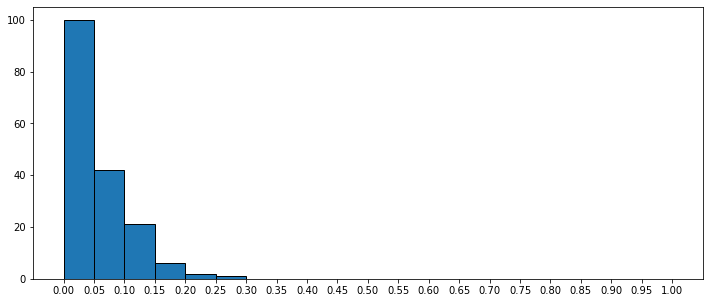

In [20]:
lr_error_values = []
for i, pred in enumerate(lr_pred):
  if pred != test_data[i].label:
    lr_error_values.append(np.abs(lr_prob[i] - .5))
plot_error_dist(lr_error_values)

## Roberta

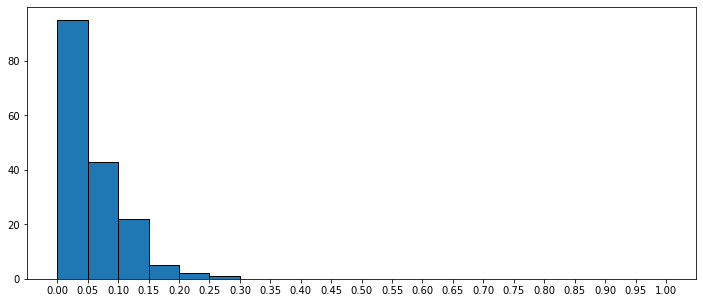

In [21]:
roberta_error_values = []
for i, pred in enumerate(roberta_pred):
  if pred != test_data[i].label:
    roberta_error_values.append(np.abs(lr_prob[i] - .5))
plot_error_dist(roberta_error_values)

## LSTM

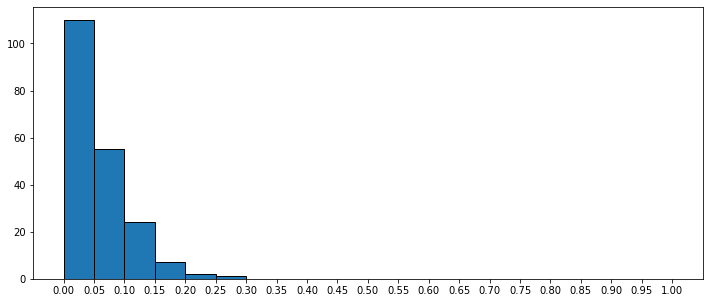

In [22]:
lstm_error_values = []
for i, pred in enumerate(lstm_pred):
  if pred != test_data[i].label:
    lstm_error_values.append(np.abs(lr_prob[i] - .5))
plot_error_dist(lstm_error_values)

# Test Ensemble (LR + NN + Roberta)

In [24]:
majority_vote = np.add(lr_pred, roberta_pred, lstm_pred)
majority_vote[majority_vote < 2] = 0
majority_vote[majority_vote > 1] = 1
test_labels = [data.label for data in test_data]
ensemble_f1 = f1_score(test_labels, majority_vote, average='macro')

In [25]:
print(f'Ensemble macro-f1: {ensemble_f1}')

Ensemble macro-f1: 0.6745688735745345
